## Comparing GNN Approaches in Molecule Identification

Firstly, we will show how original data downloaded from CompTox database via scrapping tehnique is converted into graph format

In [25]:
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit import Chem, DataStructs

Cloning github repository where the original data is

In [4]:
assays = [
    "ATG_PPARg_TRANS_dn", 
    "ATG_PPARg_TRANS_up", 
    "TOX21_PPARg_BLA_antagonist_ratio", 
    "TOX21_PPARg_BLA_Agonist_ratio", 
    "NVS_NR_hPPARg", 
    "ERF_ENZ_hCYP19A1_dn", 
    "NVS_ADME_hCYP19A1", 
    "NVS_ADME_hCYP19A1_Activator", 
    "TOX21_Aromatase_Inhibition", 
    "CEETOX_H295R_ESTRADIOL_dn", 
    "CEETOX_H295R_ESTRADIOL_noMTC_dn", 
    "CEETOX_H295R_ESTRADIOL_noMTC_up", 
    "CEETOX_H295R_ESTRADIOL_up", 
    "CEETOX_H295R_ESTRONE_dn", 
    "CEETOX_H295R_ESTRONE_noMTC_dn", 
    "CEETOX_H295R_ESTRONE_noMTC_up", 
    "CEETOX_H295R_ESTRONE_up"
]

effects = [
    "dn",
    "up",
    "dn",
    "up",
    "dn",
    "dn",
    "dn",
    "up",
    "dn",
    "dn",
    "dn",
    "up",
    "up",
    "dn",
    "dn",
    "up",
    "up"    
]

This code processes data on various biochemical tests (assays) and their results, combining them into several DataFrames. It also prepares data on SMILES strings (representations of molecules) and removes duplicates. In the end, we obtain a list of DataFrames (dfs) and a consolidated DataFrame with SMILES data (smiles).

In [5]:
# find all matching

dfs = []
smiles = []

for assay, effect in zip(assays, effects):
    path = f"data/{assay}.csv"
    df = pd.read_csv(path)
    # print(df["smiles"].isnull().sum())
    
    s = df[["preferredName", "smiles"]].copy()
    s.index = s["preferredName"]
    del s["preferredName"]
    smiles.append(s)
    
    df = df[["preferredName", "hitc"]] # only leave these two columns
    
    df = df[df["hitc"] != -1] # 22.9.2022.: remove inconclusive results
    
    df[f"effect_{assay}"] = -1 if effect == "dn" else 1
    
    df["hitc"] *= df[f"effect_{assay}"]
    
    del df[f"effect_{assay}"]
    
    df.index = df["preferredName"] 
    del df["preferredName"] # set index to name and remove the column name
    df.columns = [assay] # set type (only remaining column) to name of assay
    
    dfs.append(df)

# save for later
smiles = pd.concat(smiles, axis=0)
smiles = smiles[~smiles.index.duplicated(keep='first')]

In [7]:
smiles.isnull().sum() # should be zero, all smiles are fixed

smiles    0
dtype: int64

In [9]:
dfs[12].value_counts() #example of one csv file in dataset

CEETOX_H295R_ESTRADIOL_up
0                            514
1                             58
Name: count, dtype: int64

Method for converting smiles representation of molecule into graph structure

In [21]:

def smiles_to_graph(smiles_str, label):
    mol = Chem.MolFromSmiles(smiles_str)
    label_type = {
        0: 'inactive',
        1: 'partially active',
        2: 'active'
    }
    G = nx.Graph(label=label_type.get(label, -1))

    bond_type_mapping = {
        Chem.BondType.SINGLE: 1,
        Chem.BondType.DOUBLE: 2,
        Chem.BondType.TRIPLE: 3,
        Chem.BondType.AROMATIC: 4
    }

    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        atom_symbol = atom.GetSymbol()
        #print(f"Simbol atoma {atom_symbol}")
        atom_degree = atom.GetDegree()
        G.add_node(atom_idx, atom_label=str(atom_symbol), degree=atom_degree)

    for bond in mol.GetBonds():
        bond_type = bond.GetBondType()
        encoded_bond_type = bond_type_mapping.get(bond_type, 0)  
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), weight=encoded_bond_type, bond_type=encoded_bond_type)

    return G

In [30]:
graphs_list = list()
bad_smiles = []

In [29]:
def get_graph(row):
    print("Processing row:", row)
    try:
        molecule_label = 'active'
        if row.label == 0: molecule_label = 'inactive'
        elif row.label == 1: molecule_label = 'partially_active'
        sm = smiles.loc[row.name, 'smiles']
        print(f"SMILES for {row.name} which is {molecule_label}: {sm}")
        
        if pd.isna(sm):
            raise ValueError("SMILES string is NaN")
        graph = smiles_to_graph(sm, row.label)
        graphs_list.append(graph)
        return graph
        """ all molecules are saved into separate gml files
        gml_file = f"molecules/molecule_{row.name}_{row.label}.gml"
        nx.write_gml(graph_smile, gml_file)
        print(f"Graf za {sm} sačuvan je u {gml_file}")
        """
    except Exception as e:
        print(f"Bad smiles string for {row.name}: {e}")
        bad_smiles.append(row.name)

In [26]:
def visualize_graph(G):
    plt.figure(figsize=(12, 6))
    pos = nx.planar_layout(G) 

    nx.draw_networkx(G, pos, with_labels=False, node_color='lightblue', node_size=500, edge_color='gray')

    node_labels = nx.get_node_attributes(G, 'atom_label')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='black')

    edge_labels = nx.get_edge_attributes(G, 'bond_type')
    edge_labels_str = {
        (u, v): {1: "S", 2: "D", 3: "T", 4: "A"}.get(edge_labels[(u, v)], "Unknown")
        for u, v in edge_labels
    }
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels_str, font_color='red')

    graph_label = G.graph.get('label', 'No Label')
    plt.text(0.5, 1.05, f"Label: {graph_label}", fontsize=15, ha='center', transform=plt.gca().transAxes)

    plt.show()

label
0.0    21095
2.0     1320
1.0     1066
Name: count, dtype: int64
label
0.0    7306
1.0    1302
2.0       3
Name: count, dtype: int64
Processing row: label    1.0
Name: Tetrahydrocurcumin, dtype: float64
SMILES for Tetrahydrocurcumin which is partially_active: COC1=CC(CCC(=O)CC(=O)CCC2=CC(OC)=C(O)C=C2)=CC=C1O


C:\Users\Ivana\AppData\Local\Temp\ipykernel_484\1430130886.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assay["label"] = np.where(assay["label"] == 1, 2, assay["label"]) # up
C:\Users\Ivana\AppData\Local\Temp\ipykernel_484\1430130886.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assay["label"] = np.where(assay["label"] == -1, 1, assay["label"]) # dn
C:\Users\Ivana\AppData\Local\Temp\ipykernel_484\1430130886.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

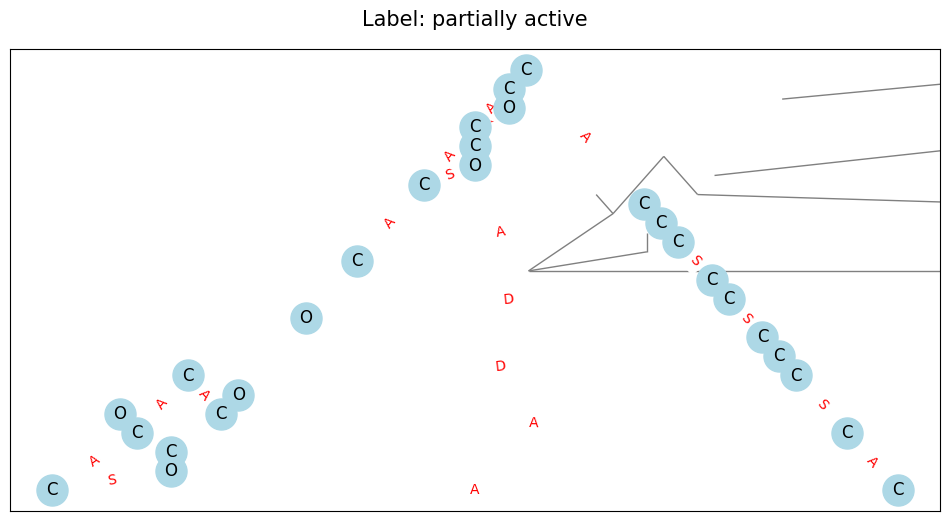

ok: 1
bad: []
bad count: 0


In [31]:
plt_count = 1
for assay, name in zip([pd.concat(dfs[0:5]), pd.concat(dfs[5:9]), pd.concat(dfs[9:17])],
                       ["ke1", "ke2", "ke3"]):

    assay["label"] = assay.sum(axis=1)

    assay = assay[["label"]]
        
    assay["label"] = np.where(assay["label"] == 1, 2, assay["label"]) # up
    assay["label"] = np.where(assay["label"] == -1, 1, assay["label"]) # dn
    
    print(assay["label"].value_counts())

    #assay.apply(lambda mol: get_graph(mol), axis=1)
    molecule = assay.iloc[0]  # Take only one molecule for demonstration
    if molecule.label == 1:
        graph = get_graph(molecule)
        visualize_graph(graph)

        print("ok:", len(graphs_list))
        print("bad:", bad_smiles)
        print("bad count:", len(bad_smiles))
        break